In [2]:
import random
import threading
import time
import math 
import matplotlib.pyplot as plt


states = ["scanning","initializing","standby","adversiting","connected"]

connectionsActive = []
lastTransmissions = []

dictOfSlaves      = {}
dictOfMaster      = {}

distances         = [0.1,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.0,
                    1.1,1.15,1.20,1.25,1.30,1.35,1.40,1.45,1.50,1.55,1.60,1.65,1.70,1.75,1.80,1.85,1.90,1.95,2.0]
errors            = []
noises            = range(0,20)

sensibilitySlave  = 0.0001
sensibilityMaster = 0.00002

powerSlave        = 10
powerMaster       = 50


In [3]:
def probabilidadeDeEnvio(distance, noise):
    if noise != -1 and distance != -1:
        return -20 * math.log(float(distance)) + 40 + float(noise)
    else:
        return 100

In [4]:
def poderDeEnvio(distance,isMaster):
    if(distance<0):
        return 100
    if(isMaster):
        return powerMaster/distance**2
    else:
        return powerSlave/distance**2
    

In [5]:
class node:
    
    def __init__(self, id, sensorRange, isMaster, numberOfReads):
        self.id            = int(id)
        self.sensorRange   = sensorRange
        self.master        = -1
        self.activate      = False
        self.isMaster      = isMaster
        self.actualState   = "standby"
        self.slaveActual   = []
        self.noiseOfConec  = 0
        self.distance      = -1
        self.buffer        = None
        self.ReadsPerCycle = numberOfReads
        self.command       = None
        self.PowerOn       = True
        self.iteration     = 0
        self.errors        = []
        self.waiting       = 0
    def leituras(self, numberOfReads):
        summ = 0
        finalRead = 0
        for i in range(0,numberOfReads):
            summ = summ + random.choice(self.sensorRange)
        finalRead = summ/len(self.sensorRange)
        return finalRead

    
    def packageMaker(self, read, destiny):
        return [self.id,destiny,read]
    
    def execution(self):
        while(self.PowerOn):
            
            
            if self.actualState == "standby":
                if(self.activate):
                    if(not self.isMaster):
                        print("[STANDBY]Node {0} is doing readings".format(self.id))
                        read = self.leituras(self.ReadsPerCycle)
                        package = self.packageMaker(read, self.master)
                        self.buffer = package
                        self.actualState = "adversiting"
                        
                    else:
                        if self.command is not None:
                            print("[STANDBY]Node Master {0} is sending commands".format(self.id))
                            package = self.packageMaker(self.command, self.slaveActual)
                            self.buffer = package
                            self.actualState = "initializing"
                        else:
                            print("[STANDBY]Node Master {0} is preparing to be available".format(self.id))
                            self.actualState = "initializing"
                else:
                    if(not self.isMaster):
                        print("[STANDBY]Node {0} is on Standby".format(self.id))
                    else:
                        print("[STANDBY]Node Master {0} is on Standby".format(self.id))
                time.sleep(1)
             
            
            
            elif self.actualState == "scanning":
                if(len(connectionsActive)>0):
                    for i in range(0,len(connectionsActive)):
                        print("[SCANNING]Node {0} is listening the connection: {1} -> {2} | Data Transmitted:{3}",
                              self.id, connectionsActive[i][0], connectionsActive[i][1], lastTransmissions[i])
                else:
                    print("[SCANNING]Node {0} is listening the connections but no connections active right now".format(self.id))
                time.sleep(1)
            
            
            elif self.actualState == "adversiting":
                print("[ADVERSITING] Node {0} is ready to send package for the his Master".format(self.id))
                self.waiting = self.waiting + 1
                time.sleep(0.5)
            
            
            elif self.actualState == "initializing":
                print("[INITIALIZING] Node Master {0} is looking for slave that is Adversiting".format(self.id))
                for slave in dictOfSlaves:
                    if(dictOfSlaves[slave].master == self.id and dictOfSlaves[slave].actualState == "adversiting"):
                        dictOfSlaves[slave].actualState = "connected"
                        self.actualState  = "connected"
                        print("[INITIALIZING] Node Master {0} was able to find Node Slave {1}".format(self.id,dictOfSlaves[slave].id))
                        break
                
                time.sleep(0.5)
                
                
            elif self.actualState == "connected":
                error = 0
                self.distance = distances[self.iteration]
                if(not self.isMaster):
                    if(dictOfMaster[self.master].buffer is not None):
                        if sensibilitySlave <= poderDeEnvio(self.distance, False):
                            while(probabilidadeDeEnvio(self.distance,self.noiseOfConec)<(random.uniform(0, 101))):
                                print("[CONNECTED] Trying to connection Node Slave {0} to Node Master {1}".format(self.id,self.master))
                                error = error + 1
                                #time.sleep(0.2)
                                if(error>99):
                                    break
                            self.errors.append(error)
                            print("[CONNECTED] Connection Node Slave {0} to Node Master {1}, Master Change the state of Slave to {2}"
                                  .format(self.id,self.master,dictOfMaster[self.master].buffer[2]))
                            self.actualState = dictOfMaster[self.master].buffer[2]
                            dictOfMaster[self.master].actualState = "standby"
                            dictOfMaster[self.master].command     = None
                            dictOfMaster[self.master].buffer      = None     
                            connectionsActive.append([self.id,self.master])
                            lastTransmissions.append(dictOfMaster[self.master].buffer[2])
                            #time.sleep(1)
                            connectionsActive.pop()
                            lastTransmissions.pop()
                            
                    else:
                        if sensibilitySlave <= poderDeEnvio(self.distance, True):
                            while(probabilidadeDeEnvio(self.distance,self.noiseOfConec)<(random.uniform(0, 101))):
                                print("[CONNECTED] Trying to connection Node Slave {0} to Node Master {1}".format(self.id,self.master))
                                error = error + 1
                                #time.sleep(0.2)
                                if(error>99):
                                    break
                            errors.append(error)    
                            print("[CONNECTED] Connection Node Slave {0} to Node Master {1}, Slave is sending to Master the data: {2}"
                                  .format(self.id,self.master,self.buffer[2]))
                            self.actualState = "standby"
                            dictOfMaster[self.master].actualState = "standby"
                            connectionsActive.append([self.id,self.master])
                            lastTransmissions.append(self.buffer[2])
                            #time.sleep(1)
                            connectionsActive.pop()
                            lastTransmissions.pop()
                            
            
                    self.iteration = self.iteration + 1
                    print("########### "+str(self.iteration)+" ############")
                    if (self.iteration>=len(distances)):
                        self.PowerOn = False
                        self.actualState = "standby"
                        self.activate      = False

# Primeiro Cenário: Conexão Bluetooth Mestre e Escravo com Conexão Variável

In [6]:
miyagi = node(0,range(-100000,0),True,100)
daniel = node(1,range(0,100),False,100)
A      = node(2,range(0,100),False,100)
B      = node(3,range(0,100),False,100)
C      = node(4,range(0,100),False,100)
D      = node(5,range(0,100),False,100)

In [7]:
miyagi.activate = True
miyagi.actualState  = "standby"

daniel.activate = True
daniel.actualState  = "standby"
daniel.master   = 0

A.activate = True
A.actualState  = "standby"
A.master   = 0

B.activate = True
B.actualState  = "standby"
B.master   = 0

C.activate = True
C.actualState  = "standby"
C.master   = 0

D.activate = True
D.actualState  = "standby"
D.master   = 0

dictOfSlaves[daniel.id] = daniel
dictOfSlaves[A.id] = A
dictOfSlaves[B.id] = B
dictOfSlaves[C.id] = C
dictOfSlaves[D.id] = D



dictOfMaster[miyagi.id] = miyagi

danielX = threading.Thread(target=dictOfSlaves[daniel.id].execution, args=())
miyagiy = threading.Thread(target=dictOfMaster[miyagi.id].execution, args=())
a = threading.Thread(target=dictOfSlaves[A.id].execution, args=())
b = threading.Thread(target=dictOfSlaves[B.id].execution, args=())
c = threading.Thread(target=dictOfSlaves[C.id].execution, args=())
d = threading.Thread(target=dictOfSlaves[D.id].execution, args=())


In [8]:
miyagiy.start()
danielX.start()
a.start()
b.start()
c.start()
d.start()

[STANDBY]Node Master 0 is preparing to be available
[STANDBY]Node 1 is doing readings
[STANDBY]Node 2 is doing readings
[STANDBY]Node 3 is doing readings
[STANDBY]Node 4 is doing readings
[STANDBY]Node 5 is doing readings
[ADVERSITING] Node 1 is ready to send package for the his Master[ADVERSITING] Node 3 is ready to send package for the his Master[ADVERSITING] Node 2 is ready to send package for the his Master


[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 1
[ADVERSITING] Node 4 is ready to send package for the his Master[ADVERSITING] Node 5 is ready to send package for the his Master

[ADVERSITING] Node 2 is ready to send package for the his Master[ADVERSITING] Node 4 is ready to send package for the his Master[ADVERSITING] Node 3 is ready to send package for the his Master

[CONNECTED] Trying to connection Node Slave 1 to Node Master 0
[CONNECTED] Connection Node Slave 1 to Node Master 0, Slave is send

[ADVERSITING] Node 2 is ready to send package for the his Master[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 3 is ready to send package for the his Master[ADVERSITING] Node 4 is ready to send package for the his Master


[ADVERSITING] Node 2 is ready to send package for the his Master[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master[ADVERSITING] Node 3 is ready to send package for the his Master


[ADVERSITING] Node 1 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 1
[ADVERSITING] Node 3 is ready to send package for the his Master[ADVERSITING] Node 5 is ready to send package for the his Master[ADVERSITING] Node 2 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master


[CONNECTED] Trying to conn

[ADVERSITING] Node 2 is ready to send package for the his Master[ADVERSITING] Node 4 is ready to send package for the his Master[ADVERSITING] Node 5 is ready to send package for the his Master[ADVERSITING] Node 3 is ready to send package for the his Master



[CONNECTED] Connection Node Slave 1 to Node Master 0, Slave is sending to Master the data: 44.88
########### 14 ############
[STANDBY]Node 1 is doing readings
[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 2 is ready to send package for the his Master[ADVERSITING] Node 3 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master

[ADVERSITING] Node 5 is ready to send package for the his Master[ADVERSITING] Node 4 is ready to send package for the his Master[ADVERSITING] Node 3 is ready to send package for the his Master
[ADVERSITING] Node 1 is ready to send package for the his Master[ADVERSITING

[CONNECTED] Connection Node Slave 1 to Node Master 0, Slave is sending to Master the data: 48.79
########### 21 ############
[STANDBY]Node 1 is doing readings
[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 4 is ready to send package for the his Master[ADVERSITING] Node 3 is ready to send package for the his Master

[ADVERSITING] Node 5 is ready to send package for the his Master[ADVERSITING] Node 2 is ready to send package for the his Master

[ADVERSITING] Node 3 is ready to send package for the his Master[ADVERSITING] Node 4 is ready to send package for the his Master

[ADVERSITING] Node 2 is ready to send package for the his Master[ADVERSITING] Node 5 is ready to send package for the his Master

[ADVERSITING] Node 1 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 1
[ADVERSITING] Node 3 is ready to send package for the his Master[ADVERSITIN

[ADVERSITING] Node 1 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 1
[ADVERSITING] Node 4 is ready to send package for the his Master[ADVERSITING] Node 3 is ready to send package for the his Master

[ADVERSITING] Node 5 is ready to send package for the his Master[ADVERSITING] Node 2 is ready to send package for the his Master

[CONNECTED] Connection Node Slave 1 to Node Master 0, Slave is sending to Master the data: 49.29
########### 28 ############
[STANDBY]Node 1 is doing readings
[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 3 is ready to send package for the his Master[ADVERSITING] Node 4 is ready to send package for the his Master

[ADVERSITING] Node 2 is ready to send package for the his Master[ADVERSITING] Node 5 is ready to send package for the his Master

[ADVERSITING] Node 3 is ready to send package for the his Master[ADVERSITIN

[ADVERSITING] Node 5 is ready to send package for the his Master[ADVERSITING] Node 3 is ready to send package for the his Master

[ADVERSITING] Node 4 is ready to send package for the his Master[ADVERSITING] Node 2 is ready to send package for the his Master

[ADVERSITING] Node 1 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 1
[ADVERSITING] Node 3 is ready to send package for the his Master[ADVERSITING] Node 5 is ready to send package for the his Master

[ADVERSITING] Node 4 is ready to send package for the his Master[ADVERSITING] Node 2 is ready to send package for the his Master

[CONNECTED] Connection Node Slave 1 to Node Master 0, Slave is sending to Master the data: 52.09
########### 35 ############
[STANDBY]Node 1 is doing readings
[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 5 is ready to send package for the his Master[ADVERSITIN

[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 3 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 3 is ready to send package for the his Master[ADVERSITING] Node 2 is ready to send package for the his Master

[ADVERSITING] Node 5 is ready to send package for the his Master[ADVERSITING] Node 4 is ready to send package for the his Master

[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 2
[CONNECTED] Connection Node Slave 2 to Node Master 0, Slave is sending to Master the data: 48.12[ADVERSITING] Node 3 is ready to send package for the his Master

########### 4 ############
[STANDBY]Node 2 is doing readings
[ADVERSITING] Node 4 is ready to send package for the his Master[ADVERSITING] Node 5 is ready to send package for the his Master

[STANDBY]No

[ADVERSITING] Node 3 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master[ADVERSITING] Node 5 is ready to send package for the his Master

[ADVERSITING] Node 2 is ready to send package for the his Master
[ADVERSITING] Node 3 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master[ADVERSITING] Node 5 is ready to send package for the his Master

[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 2
[CONNECTED] Connection Node Slave 2 to Node Master 0, Slave is sending to Master the data: 49.75
########### 12 ############
[STANDBY]Node 2 is doing readings
[ADVERSITING] Node 3 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master[ADVERSITING] Node 5 is ready to send package for the his Master

[STANDBY]Node Master 0 is preparing to be available
[ADVERSITI

[CONNECTED] Trying to connection Node Slave 2 to Node Master 0
[CONNECTED] Connection Node Slave 2 to Node Master 0, Slave is sending to Master the data: 53.72
########### 19 ############
[STANDBY]Node 2 is doing readings
[ADVERSITING] Node 3 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master[ADVERSITING] Node 5 is ready to send package for the his Master

[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 3 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 2 is ready to send package for the his Master
[ADVERSITING] Node 3 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master[ADVERSITING] Node 4 is ready to send package for the his Master

[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITI

[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 2
[CONNECTED] Connection Node Slave 2 to Node Master 0, Slave is sending to Master the data: 45.59
########### 27 ############
[STANDBY]Node 2 is doing readings
[ADVERSITING] Node 3 is ready to send package for the his Master[ADVERSITING] Node 4 is ready to send package for the his Master

[ADVERSITING] Node 5 is ready to send package for the his Master
[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 3 is ready to send package for the his Master[ADVERSITING] Node 4 is ready to send package for the his Master

[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 2 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master[ADVERSITING] Node 3 is ready to send package for the his Master

[ADVERSITING] Node 5 is ready to send package for the his Master
[INITIALIZ

[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 4 is ready to send package for the his Master[ADVERSITING] Node 3 is ready to send package for the his Master

[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 2 is ready to send package for the his Master
[ADVERSITING] Node 3 is ready to send package for the his Master[ADVERSITING] Node 4 is ready to send package for the his Master

[ADVERSITING] Node 5 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 2
[CONNECTED] Trying to connection Node Slave 2 to Node Master 0
[CONNECTED] Trying to connection Node Slave 2 to Node Master 0
[CONNECTED] Trying to connection Node Slave 2 to Node Master 0
[CONNECTED] Connection Node Slave 2 to Node Master 0, Slave is sending to Master the data: 51.32
########### 35 ############
[STANDBY]Node 2 is doing readings
[ADVERSITING] No

[CONNECTED] Trying to connection Node Slave 3 to Node Master 0
[CONNECTED] Trying to connection Node Slave 3 to Node Master 0
[CONNECTED] Trying to connection Node Slave 3 to Node Master 0
[CONNECTED] Trying to connection Node Slave 3 to Node Master 0
[CONNECTED] Trying to connection Node Slave 3 to Node Master 0
[CONNECTED] Connection Node Slave 3 to Node Master 0, Slave is sending to Master the data: 48.26
########### 5 ############
[STANDBY]Node 3 is doing readings
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master
[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 3 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master
[INITIALIZING] Node 

[ADVERSITING] Node 3 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 3
[CONNECTED] Connection Node Slave 3 to Node Master 0, Slave is sending to Master the data: 50.8
########### 15 ############
[STANDBY]Node 3 is doing readings
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master
[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 3 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master
[INITIALIZI

[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 3 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 3
[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master
[CONNECTED] Trying to connection Node Slave 3 to Node Master 0
[CONNECTED] Trying to connection Node Slave 3 to Node Master 0
[CONNECTED] Connection Node Slave 3 to Node Master 0, Slave is sending to Master the data: 54.67
########### 25 ############
[STANDBY]Node 3 is doing readings
[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] 

[CONNECTED] Trying to connection Node Slave 3 to Node Master 0
[CONNECTED] Trying to connection Node Slave 3 to Node Master 0
[CONNECTED] Connection Node Slave 3 to Node Master 0, Slave is sending to Master the data: 51.13
########### 33 ############
[STANDBY]Node 3 is doing readings
[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 3 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 3
[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master
[CONNECTED] Trying to connection Node Slave 3 to Node Master 0
[CONNECTED] Tryi

[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 4
[ADVERSITING] Node 5 is ready to send package for the his Master[CONNECTED] Connection Node Slave 4 to Node Master 0, Slave is sending to Master the data: 46.7

########### 5 ############
[STANDBY]Node 4 is doing readings
[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 4
[CONNECTED] Connection Node Slave 4 to Node Master 0, Slave is sending to Master the data: 49.76
########### 6 ############
[STANDBY]Node 4 is doing readings
[ADVERSITING] Node 5 is ready to send package for the his Master
[STANDBY]Node Master 0 is preparing to be availabl

[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 4
[CONNECTED] Trying to connection Node Slave 4 to Node Master 0
[CONNECTED] Trying to connection Node Slave 4 to Node Master 0
[CONNECTED] Trying to connection Node Slave 4 to Node Master 0
[CONNECTED] Trying to connection Node Slave 4 to Node Master 0
[CONNECTED] Trying to connection Node Slave 4 to Node Master 0
[CONNECTED] Connection Node Slave 4 to Node Master 0, Slave is sending to Master the data: 51.29
########### 18 ############
[STANDBY]Node 4 is doing readings
[ADVERSITING] Node 5 is ready to send package for the his Master
[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 5

[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 4
[CONNECTED] Trying to connection Node Slave 4 to Node Master 0
[CONNECTED] Connection Node Slave 4 to Node Master 0, Slave is sending to Master the data: 51.25
########### 30 ############
[STANDBY]Node 4 is doing readings
[ADVERSITING] Node 5 is ready to send package for the his Master
[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 5 is ready to send package for the his Master
[ADVERSITING] Node 4 is ready to send package for the his Master
[ADVERSITING] Node 5 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node 

[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 5 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 5
[CONNECTED] Trying to connection Node Slave 5 to Node Master 0
[CONNECTED] Connection Node Slave 5 to Node Master 0, Slave is sending to Master the data: 53.03
########### 5 ############
[STANDBY]Node 5 is doing readings
[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 5 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 5
[CONNECTED] Connection Node Slave 5 to Node Master 0, Slave is sending to Master the data: 47.58
########### 6 ############
[STANDBY]Node 5 is doing readings
[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 5 is ready to send package for the his Master
[INITIALIZIN

[CONNECTED] Connection Node Slave 5 to Node Master 0, Slave is sending to Master the data: 48.2
########### 22 ############
[STANDBY]Node 5 is doing readings
[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 5 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 5
[CONNECTED] Trying to connection Node Slave 5 to Node Master 0
[CONNECTED] Connection Node Slave 5 to Node Master 0, Slave is sending to Master the data: 46.28
########### 23 ############
[STANDBY]Node 5 is doing readings
[STANDBY]Node Master 0 is preparing to be available
[ADVERSITING] Node 5 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 5
[CONNECTED] Trying to connection Node Slave 5 to Node Master 0
[CONNECTED] Trying to connection Node Slave 5 to Node Master 0
[C

[ADVERSITING] Node 5 is ready to send package for the his Master
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 was able to find Node Slave 5
[CONNECTED] Trying to connection Node Slave 5 to Node Master 0
[CONNECTED] Trying to connection Node Slave 5 to Node Master 0
[CONNECTED] Trying to connection Node Slave 5 to Node Master 0
[CONNECTED] Trying to connection Node Slave 5 to Node Master 0
[CONNECTED] Trying to connection Node Slave 5 to Node Master 0
[CONNECTED] Trying to connection Node Slave 5 to Node Master 0
[CONNECTED] Connection Node Slave 5 to Node Master 0, Slave is sending to Master the data: 47.63
########### 38 ############
[STANDBY]Node Master 0 is preparing to be available
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 is looking f

[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting
[INITIALIZING] Node Master 0 is looking for slave that is Adversiting


In [9]:
miyagi.PowerOn = False

[INITIALIZING] Node Master 0 is looking for slave that is Adversiting


In [15]:
len(dictOfSlaves[1].errors)

0

ValueError: x and y must have same first dimension, but have shapes (38,) and (0,)

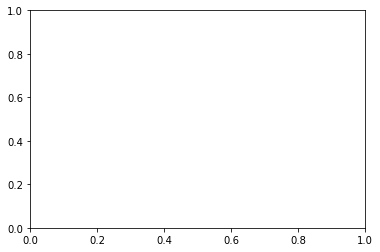

In [12]:
plt.plot(distances, dictOfSlaves[1].errors)
plt.ylabel('error')
plt.xlabel('distance')

plt.show()

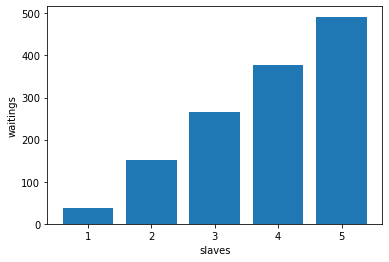

In [11]:
plt.bar([1,2,3,4,5], [dictOfSlaves[1].waiting,dictOfSlaves[2].waiting,dictOfSlaves[3].waiting,dictOfSlaves[4].waiting,dictOfSlaves[5].waiting])
plt.ylabel('waitings')
plt.xlabel('slaves')

plt.show()